<a href="https://colab.research.google.com/github/Hhhdhfgvgbh/prediction_of_rebar_cost/blob/main/out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [1]:
pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from skopt import BayesSearchCV

In [3]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import catboost as cb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings("ignore")

# Загрузка и предобработка

In [5]:
test = pd.read_excel('test.xlsx')
test_dat_list =  pd.to_datetime(test['dt'])
test_dat_list.head(3)

0   2022-09-05
1   2022-09-12
2   2022-09-19
Name: dt, dtype: datetime64[ns]

In [6]:
test['Цена на арматуру']

0     46000
1     46000
2     46000
3     45500
4     45500
5     45000
6     44000
7     43000
8     42000
9     41500
10    41000
11    40000
12    40000
13    40500
14    41700
15    41700
16    42500
17    42700
18    42700
19    42700
20    42800
21    42800
22    44500
23    44500
24    46000
25    49200
26    53700
27    55500
Name: Цена на арматуру, dtype: int64

In [7]:
# for i in os.listdir('D:\DATA_SCIENCE\hacks_ai\data'):
#     print(i)

In [8]:
train = pd.read_excel('train.xlsx')
cargo = pd.read_excel('Грузоперевозки.xlsx')
materials = pd.read_excel('Данные рынка стройматериалов.xlsx')
makro_index = pd.read_excel('Макропоказатели.xlsx')
metal_index = pd.read_excel('Показатели рынка металла.xlsx')
benz_index = pd.read_excel('Топливо.xlsx')
res_index = pd.read_excel('Цены на сырье.xlsx')

In [9]:
makro_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672 entries, 0 to 1671
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   dt                                                     1672 non-null   datetime64[ns]
 1   Базовый индекс потребительских цен на товары и услуги  29 non-null     float64       
 2   Ключевая ставка                                        1365 non-null   float64       
 3   Курс доллара                                           1338 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 52.4 KB


In [10]:
makro_index.tail()

,dt,Базовый индекс потребительских цен на товары и услуги,Ключевая ставка,Курс доллара
1667,2023-06-10,NaN,NaN,82.6417
1668,2023-06-13,NaN,7.5,NaN
1669,2023-06-14,NaN,7.5,83.6405
1670,2023-06-15,NaN,7.5,84.3249
1671,2023-06-16,NaN,7.5,83.9611


In [11]:
sum(makro_index['dt'].duplicated())

0

In [12]:
CHMF = pd.read_csv('CHMF Акции.csv')
MAGN = pd.read_csv('MAGN Акции.csv')
NLMK = pd.read_csv('NLMK Акции.csv')

In [13]:
cargo['dt'] = pd.to_datetime(cargo['dt'])
train['dt'] = pd.to_datetime(train['dt'])
materials['dt'] = pd.to_datetime(materials['dt'])
makro_index['dt'] = pd.to_datetime(makro_index['dt'])
metal_index['dt'] = pd.to_datetime(metal_index['dt'])
benz_index['dt'] = pd.to_datetime(benz_index['dt'])
res_index['dt'] = pd.to_datetime(res_index['dt'])

In [14]:
NLMK['dt'] = pd.to_datetime(NLMK['Date'], format="%m/%d/%Y")
NLMK.tail(3)

,Date,Price,Open,High,Low,Vol.,Change %,dt
1050,01/08/2019,150.12,150.98,151.34,149.64,3.12M,-3.57%,2019-01-08
1051,01/04/2019,155.68,156.80,157.46,154.80,2.91M,-1.06%,2019-01-04
1052,01/03/2019,157.34,155.86,157.34,154.80,2.90M,-0.05%,2019-01-03


In [15]:
NLMK = NLMK.drop(columns = 'Date')
NLMK.columns = ['Price_nl', 'Open_nl', 'High_nl', 'Low_nl', 'Vol_nl', 'Change_nl', 'dt']
NLMK['Change_nl'] = NLMK['Change_nl'].str.replace('%', '')
NLMK['Vol_nl'] = NLMK['Vol_nl'].str.replace('M', '')
NLMK['Vol_nl'] = NLMK['Vol_nl'].str.replace('K', '')
NLMK['Vol_nl'] = NLMK['Vol_nl'].astype(float)
NLMK['Change_nl'] = NLMK['Change_nl'].astype(float)
NLMK['Price_nl'] = NLMK['Price_nl'].astype(float)
NLMK['Open_nl'] = NLMK['Open_nl'].astype(float)
NLMK['High_nl'] = NLMK['High_nl'].astype(float)
NLMK['Low_nl'] = NLMK['Low_nl'].astype(float)
NLMK.loc[NLMK['Vol_nl'] > 100, 'Vol_nl'] = NLMK.loc[NLMK['Vol_nl'] > 100, 'Vol_nl'] / 1000

In [16]:
CHMF['dt'] = pd.to_datetime(CHMF['Date'], format="%m/%d/%Y")
CHMF.head(2)

,Date,Price,Open,High,Low,Vol.,Change %,dt
0,03/31/2023,"1,043.20","1,061.00","1,061.00","1,042.00",571.72K,-1.68%,2023-03-31
1,03/30/2023,"1,061.00","1,074.60","1,084.80","1,058.00",1.30M,-1.27%,2023-03-30


In [17]:
CHMF.columns = ['Date', 'Price_ch', 'Open_ch', 'High_ch', 'Low_ch', 'Vol_ch', 'Change_ch', 'dt']
CHMF = CHMF.drop(columns = 'Date')
CHMF['Change_ch'] = CHMF['Change_ch'].str.replace('%', '')
CHMF['Vol_ch'] = CHMF['Vol_ch'].str.replace('M', '')
CHMF['Vol_ch'] = CHMF['Vol_ch'].str.replace('K', '')
CHMF['Vol_ch'] = CHMF['Vol_ch'].astype(float)
CHMF['Change_ch'] = CHMF['Change_ch'].astype(float)

CHMF['Price_ch'] = CHMF['Price_ch'].str.replace(',', '')
CHMF['Price_ch'] = CHMF['Price_ch'].str.replace('.', '', n = 1)
CHMF['Open_ch'] = CHMF['Open_ch'].str.replace(',', '')
CHMF['High_ch'] = CHMF['High_ch'].str.replace(',', '')
CHMF['Low_ch'] = CHMF['Low_ch'].str.replace(',', '')

CHMF['Price_ch'] = CHMF['Price_ch'].astype(float)
CHMF['Open_ch'] = CHMF['Open_ch'].astype(float)
CHMF['High_ch'] = CHMF['High_ch'].astype(float)
CHMF['Low_ch'] = CHMF['Low_ch'].astype(float)
CHMF.loc[CHMF['Vol_ch'] > 100, 'Vol_ch'] = CHMF.loc[CHMF['Vol_ch'] > 100, 'Vol_ch'] / 1000


In [18]:
MAGN['dt'] = pd.to_datetime(MAGN['Дата'], format="%d.%m.%Y")
MAGN.head(2)

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,dt
0,31.03.2023,"39,69","40,21","40,24","39,52","18,23M","-1,38%",2023-03-31
1,30.03.2023,"40,24","40,60","41,00","40,02","27,14M","-0,87%",2023-03-30


In [19]:
MAGN = MAGN.drop(columns = 'Дата')
MAGN['Изм. %'] = MAGN['Изм. %'].str.replace('%', '')
MAGN['Объём'] = MAGN['Объём'].str.replace('M', '')
MAGN['Объём'] = MAGN['Объём'].str.replace('K', '')
#MAGN['Изм. %'] = MAGN['Изм. %'].astype(float)
#MAGN['Объём'] = MAGN['Объём'].astype(float)

MAGN['Цена'] = MAGN['Цена'].str.replace(',', '.')
MAGN['Объём'] = MAGN['Объём'].str.replace(',', '.')
MAGN['Мин.'] = MAGN['Мин.'].str.replace(',', '.')
MAGN['Откр.'] = MAGN['Откр.'].str.replace(',', '.')
MAGN['Макс.'] = MAGN['Макс.'].str.replace(',', '.')
MAGN['Изм. %'] = MAGN['Изм. %'].str.replace(',', '.')

MAGN['Объём'] = MAGN['Объём'].astype(float)
MAGN['Изм. %'] = MAGN['Изм. %'].astype(float)
MAGN['Цена'] = MAGN['Цена'].astype(float)
MAGN['Мин.'] = MAGN['Мин.'].astype(float)
MAGN['Откр.'] = MAGN['Откр.'].astype(float)
MAGN['Макс.'] = MAGN['Макс.'].astype(float)
MAGN.loc[MAGN['Объём'] > 100, 'Объём'] = MAGN.loc[MAGN['Объём'] > 100, 'Объём'] / 1000

<Axes: xlabel='dt'>

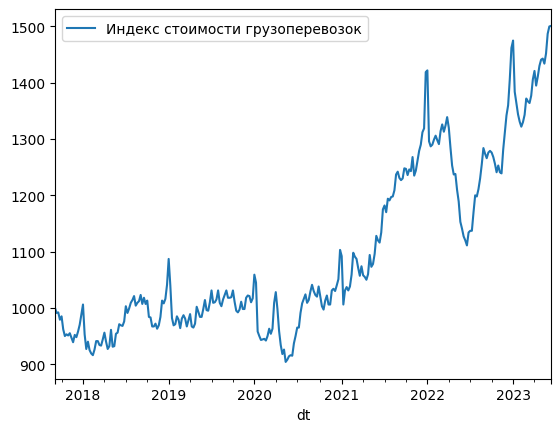

In [20]:
cargo.plot(x = 'dt', y = 'Индекс стоимости грузоперевозок')

<Axes: xlabel='dt'>

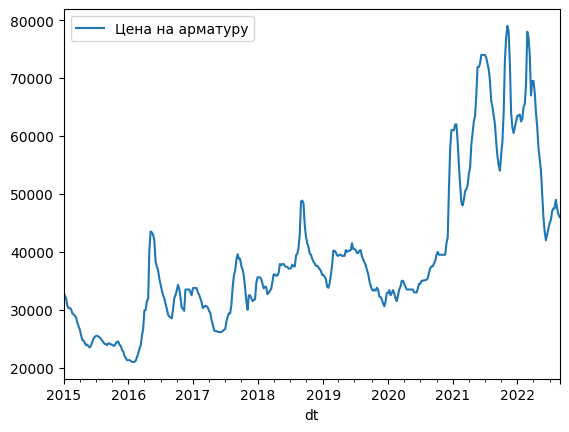

In [21]:
train.plot(x = 'dt', y = 'Цена на арматуру')

In [22]:
CHMF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Price_ch   1054 non-null   float64       
 1   Open_ch    1054 non-null   float64       
 2   High_ch    1054 non-null   float64       
 3   Low_ch     1054 non-null   float64       
 4   Vol_ch     1053 non-null   float64       
 5   Change_ch  1054 non-null   float64       
 6   dt         1054 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 57.8 KB


In [23]:
df_all = train.merge(cargo, how='outer').merge(materials
                                      , how='outer').merge(makro_index
                                                           , how='outer').merge(metal_index
                                                                                , how='outer').merge(benz_index
                                                                                                     , how='outer').merge(res_index
                                                                                                                          , how='outer').merge(CHMF
                                                                                                                                               , how='outer').merge(MAGN
                                                                                                                                                                    , how='outer').merge(NLMK, how='outer')

In [24]:
#df_all = pd.concat([train, cargo, materials, makro_index
#           , metal_index, benz_index, res_index, CHMF, MAGN, NLMK], axis = 0, ignore_index = True).sort_values(by = 'dt')

In [25]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880 entries, 0 to 1879
Columns: 178 entries, dt to Change_nl
dtypes: datetime64[ns](1), float64(177)
memory usage: 2.6 MB


In [26]:
df_all.index = df_all['dt']
df_all = df_all.sort_index()

In [27]:
df_all[df_all['dt'].duplicated()]

,dt,Цена на арматуру,Индекс стоимости грузоперевозок,Импорт цемента ЖД,Экспорт цемента ЖД,Отгрузка цемента хоппер ЖД,Отгрузка цемента остальные ЖД,Производство цемента,Импорт цемента,Экспорт цемента,...,Макс.,Мин.,Объём,Изм. %,Price_nl,Open_nl,High_nl,Low_nl,Vol_nl,Change_nl
dt,,,,,,,,,,,,,,,,,,,,,


In [28]:
df_all =  df_all.drop(columns = 'dt')

In [29]:
df_all.head()

,Цена на арматуру,Индекс стоимости грузоперевозок,Импорт цемента ЖД,Экспорт цемента ЖД,Отгрузка цемента хоппер ЖД,Отгрузка цемента остальные ЖД,Производство цемента,Импорт цемента,Экспорт цемента,Потребление цемента,...,Макс.,Мин.,Объём,Изм. %,Price_nl,Open_nl,High_nl,Low_nl,Vol_nl,Change_nl
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-05,32900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-12,32500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-19,32000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-26,30700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-02,30300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
for i in df_all.columns[1:]:
    df_all[i] = df_all[i].interpolate()

In [31]:
#sum(df_all.loc[df_all['Цена на арматуру'].notnull(), :].duplicated())

In [32]:
sum(df_all[df_all['Цена на арматуру'].notnull()].index.duplicated())

0

In [33]:
df_all = df_all.loc[set(df_all[df_all['Цена на арматуру'].notnull()].index) | set(test_dat_list), :]

In [34]:
df_all = df_all[df_all['Производство цемента'].notnull()]

In [35]:
df_all['Цена на арматуру'].isna()

dt
2023-01-16     True
2021-07-26    False
2022-02-07    False
2022-07-04    False
2021-12-06    False
              ...  
2023-01-09     True
2023-01-23     True
2022-05-09    False
2022-08-22    False
2021-05-31    False
Name: Цена на арматуру, Length: 98, dtype: bool

In [36]:
df_all.loc[set(df_all[df_all['Цена на арматуру'].notnull()].index), :]

,Цена на арматуру,Индекс стоимости грузоперевозок,Импорт цемента ЖД,Экспорт цемента ЖД,Отгрузка цемента хоппер ЖД,Отгрузка цемента остальные ЖД,Производство цемента,Импорт цемента,Экспорт цемента,Потребление цемента,...,Макс.,Мин.,Объём,Изм. %,Price_nl,Open_nl,High_nl,Low_nl,Vol_nl,Change_nl
dt,,,,,,,,,,,,,,,,,,,,,
2022-05-23,50000.0,1165.000000,71.309942,51.658681,1161.066121,266.501319,3.286437,104.538298,57.761481,3.300585,...,43.800000,40.470000,12.750000,-5.700000,151.360000,157.020000,157.840000,150.300000,1.230000,-2.940000
2021-08-16,65000.0,1205.333333,124.765500,100.692000,1807.062500,616.531000,5.289950,187.928630,123.529525,5.348099,...,68.700000,67.770000,12.930000,-0.500000,251.220000,250.000000,252.920000,249.640000,7.420000,0.140000
2022-01-10,63500.0,1359.000000,98.925130,110.382870,1709.046696,748.083739,6.154326,183.703689,129.539585,6.310381,...,71.800000,70.180000,37.940000,-1.080000,212.320000,214.620000,215.820000,210.500000,5.670000,-0.700000
2022-02-14,65500.0,1300.666667,104.525664,85.644800,1711.822050,475.634551,5.449700,182.135812,98.666530,5.450569,...,64.420000,60.120000,45.740000,1.990000,228.020000,220.960000,230.500000,216.540000,15.810000,2.960000
2022-03-07,77000.0,1324.000000,95.632819,68.502683,1550.847333,330.971486,4.583230,151.753022,76.993041,4.547786,...,52.238261,45.231304,64.086087,-0.998261,179.652174,179.203478,206.206087,160.975652,18.069565,0.141739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-11,67500.0,1296.666667,68.887988,61.036190,1191.565774,259.868607,3.430365,109.552416,67.015661,3.331075,...,43.400000,41.250000,8.990000,-2.290000,157.200000,161.160000,161.440000,156.420000,1.980000,-2.450000
2021-12-27,62500.0,1385.666667,99.177370,113.703741,1712.785741,809.739148,6.261433,183.299777,133.690535,6.444780,...,68.400000,66.470000,17.700000,2.420000,214.600000,212.400000,215.000000,211.900000,4.540000,1.040000
2022-08-15,47500.0,1223.666667,105.303419,77.228861,1689.662307,535.372894,5.414163,142.472388,91.271388,5.397834,...,27.140000,25.700000,29.910000,3.620000,117.960000,117.680000,117.960000,115.700000,2.900000,0.680000


# Дополнение
Нужно наделать фичей рессемплированием, сдвигом и прочими методами работы с временными рядами. Сейчас не успел, утром доделаю.

# Подготовка и обучение моделей

In [37]:
train_x, test_x = train_test_split(df_all.loc[set(df_all[df_all['Цена на арматуру'].notnull()].index), :]
                               , shuffle=False, test_size=0.1, random_state = 123)

In [38]:
X_tr = train_x.drop(columns = 'Цена на арматуру').fillna(0)
Y_tr = train_x['Цена на арматуру']

X_te = test_x.drop(columns = 'Цена на арматуру').fillna(0)
Y_te = test_x['Цена на арматуру']

In [39]:
X_tr

,Индекс стоимости грузоперевозок,Импорт цемента ЖД,Экспорт цемента ЖД,Отгрузка цемента хоппер ЖД,Отгрузка цемента остальные ЖД,Производство цемента,Импорт цемента,Экспорт цемента,Потребление цемента,Отгрузка цемента,...,Макс.,Мин.,Объём,Изм. %,Price_nl,Open_nl,High_nl,Low_nl,Vol_nl,Change_nl
dt,,,,,,,,,,,,,,,,,,,,,
2022-05-23,1165.000000,71.309942,51.658681,1161.066121,266.501319,3.286437,104.538298,57.761481,3.300585,1.427567,...,43.800000,40.470000,12.750000,-5.700000,151.360000,157.020000,157.840000,150.300000,1.230000,-2.940000
2021-08-16,1205.333333,124.765500,100.692000,1807.062500,616.531000,5.289950,187.928630,123.529525,5.348099,2.423593,...,68.700000,67.770000,12.930000,-0.500000,251.220000,250.000000,252.920000,249.640000,7.420000,0.140000
2022-01-10,1359.000000,98.925130,110.382870,1709.046696,748.083739,6.154326,183.703689,129.539585,6.310381,2.457130,...,71.800000,70.180000,37.940000,-1.080000,212.320000,214.620000,215.820000,210.500000,5.670000,-0.700000
2022-02-14,1300.666667,104.525664,85.644800,1711.822050,475.634551,5.449700,182.135812,98.666530,5.450569,2.187457,...,64.420000,60.120000,45.740000,1.990000,228.020000,220.960000,230.500000,216.540000,15.810000,2.960000
2022-03-07,1324.000000,95.632819,68.502683,1550.847333,330.971486,4.583230,151.753022,76.993041,4.547786,1.881836,...,52.238261,45.231304,64.086087,-0.998261,179.652174,179.203478,206.206087,160.975652,18.069565,0.141739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-06,1234.666667,124.674731,118.447654,1886.210923,689.465346,5.854192,198.167498,146.879160,5.938100,2.575676,...,79.510000,76.180000,28.950000,3.310000,237.380000,233.880000,237.940000,232.180000,17.220000,-3.630000
2022-02-28,1306.333333,103.235327,68.553600,1645.572100,351.013102,4.889700,162.411976,77.514070,4.864498,1.996585,...,52.737391,45.346957,50.789130,-1.427391,177.978261,183.805217,203.199130,160.963478,21.204348,-1.337391
2022-05-09,1215.600000,63.603108,48.778571,1072.464188,245.292640,3.040725,93.425952,53.374371,2.939202,1.317757,...,44.700000,43.703333,3.723333,0.243333,160.253333,159.560000,161.266667,157.580000,1.004443,-0.223333


In [40]:
sum(X_tr.isna().sum())

0

In [41]:
splits = TimeSeriesSplit(n_splits=8)

In [42]:
model_l_r = LinearRegression()
cross_l_r = cross_val_score(model_l_r, X_tr, Y_tr, scoring = 'neg_root_mean_squared_error', cv=splits)
RMSE_l_r = abs(cross_l_r.mean())
print(f'RMSE линейной регрессии:{RMSE_l_r}')

RMSE линейной регрессии:9106.309115933342


In [43]:
d_t_r = DecisionTreeRegressor()
parametrs = { 'max_depth': range (4, 13, 2),
              'min_samples_leaf': range (1, 8),
              'min_samples_split': range (2, 10, 2),
            }
grid_d_t_r = GridSearchCV(d_t_r, parametrs, scoring = 'neg_root_mean_squared_error', cv=splits)
grid_d_t_r.fit(X_tr, Y_tr)
RMSE_d_t_r = abs(grid_d_t_r.best_score_)
print(f'RMSE решающего дерева:{RMSE_d_t_r}')

RMSE решающего дерева:4818.255299661347


In [44]:
cb_r = cb.CatBoostRegressor(loss_function='RMSE', verbose= False)
cb_r.fit(X_tr, Y_tr)
#params = {'depth': [7, 10, 14], 'learning_rate': [0.08, 0.2, 0.5], 'l2_leaf_reg': [1, 4, 8]}
#cb_grid = BayesSearchCV(cb_r, params, cv = splits, scoring = 'neg_root_mean_squared_error', n_iter=10)
mean_squared_error(Y_te, cb_r.predict(X_te))**0.5

974.484405981867

In [45]:
df_all.loc[test_dat_list, :].drop(columns = 'Цена на арматуру')

,Индекс стоимости грузоперевозок,Импорт цемента ЖД,Экспорт цемента ЖД,Отгрузка цемента хоппер ЖД,Отгрузка цемента остальные ЖД,Производство цемента,Импорт цемента,Экспорт цемента,Потребление цемента,Отгрузка цемента,...,Макс.,Мин.,Объём,Изм. %,Price_nl,Open_nl,High_nl,Low_nl,Vol_nl,Change_nl
dt,,,,,,,,,,,,,,,,,,,,,
2022-09-05,1277.333333,93.841920,77.612920,1741.533598,639.985096,5.935323,140.760886,97.752504,5.953308,2.381519,...,30.420000,29.70,12.470000,1.33,126.000000,123.000000,126.00,121.580000,4.690000,2.860000
2022-09-12,1268.666667,91.125556,77.621860,1770.621879,660.942744,6.068708,150.678622,97.725465,6.136053,2.431565,...,29.900000,28.78,14.690000,2.57,119.780000,117.500000,121.70,117.480000,7.280000,1.720000
2022-09-19,1272.666667,88.409192,77.630800,1799.710161,681.900392,6.202092,160.596357,97.698426,6.318798,2.481611,...,30.760000,29.65,15.650000,-0.88,116.700000,117.240000,117.96,115.900000,3.900000,-0.380000
2022-09-26,1278.000000,85.692828,77.639740,1828.798442,702.858040,6.335477,170.514093,97.671387,6.501543,2.531656,...,25.240000,22.00,51.150000,-9.18,77.300000,90.360000,91.14,77.040000,19.460000,-15.630000
2022-10-03,1277.000000,86.729209,78.188898,1856.344498,725.172858,6.452692,179.373723,98.193656,6.645334,2.581517,...,26.190000,23.76,33.120000,7.26,86.760000,85.460000,88.26,82.200000,12.090000,2.190000
2022-10-10,1270.666667,95.271082,79.818491,1880.806104,750.202016,6.537569,186.117143,99.814542,6.711218,2.631008,...,25.580000,23.37,28.620000,5.54,78.120000,71.980000,78.22,70.400000,13.720000,5.710000
2022-10-17,1260.000000,103.812954,81.448084,1905.267709,775.231175,6.622446,192.860562,101.435428,6.777102,2.680499,...,28.160000,26.24,35.040000,7.57,87.720000,83.100000,87.72,82.140000,12.330000,6.380000
2022-10-24,1246.000000,112.354827,83.077677,1929.729315,800.260333,6.707323,199.603982,103.056314,6.842986,2.729990,...,29.800000,28.33,48.450000,2.52,93.460000,94.520000,95.26,92.020000,9.120000,-0.910000
2022-10-31,1249.000000,120.896700,84.707270,1954.190920,825.289492,6.792200,206.347401,104.677200,6.908870,2.779480,...,32.210000,30.80,25.360000,-2.68,103.080000,106.260000,106.26,101.820000,8.620000,-2.740000


# Дополнение
Нужно зафиксировать рандом, убрать лишние фичи, перебрать гиперпараметры. Не успел, сделаю утром.

In [46]:
# cb_r = cb.CatBoostRegressor(loss_function='RMSE', iterations=75, verbose=75)
# params = {'depth': [7, 10, 14], 'learning_rate': [0.08, 0.2, 0.5], 'l2_leaf_reg': [1, 4, 8]}
# cb_grid = BayesSearchCV(cb_r, params, cv = splits, scoring = 'neg_root_mean_squared_error', n_iter=10)
# cb_grid.fit(X_tr, Y_tr)
# RMSE_cb = abs(cb_grid.best_score_)
# print(f'RMSE CatBoost:{RMSE_cb}')

# Решение задачи и выгрузка ответа

In [47]:
test

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000
3,2022-09-26,45500
4,2022-10-03,45500
5,2022-10-10,45000
6,2022-10-17,44000
7,2022-10-24,43000
8,2022-10-31,42000
9,2022-11-07,41500


In [48]:
cb_r.predict(df_all.loc[test_dat_list, :].drop(columns = 'Цена на арматуру'))

array([46376.74191033, 48293.74170961, 50243.2791623 , 51276.84152067,
       51886.55084873, 52681.56569589, 52506.77846823, 53478.33289762,
       52799.51976855, 53775.56559661, 53455.87557797, 54179.71097843,
       54527.02330244, 54805.00198419, 54335.91366268, 54379.00400614,
       54754.98725845, 54430.14234105, 54796.95232785, 54229.05964924,
       52885.1484162 , 52714.16776549, 52572.41812211, 53362.72560784,
       54103.10436715, 53961.06596753, 55673.1007661 , 56505.71507431])

In [49]:
mean_squared_error(test['Цена на арматуру'], cb_r.predict(df_all.loc[test_dat_list, :].drop(columns = 'Цена на арматуру')))**0.5

9824.060643776367

In [50]:
test['Цена_ predict'] = cb_r.predict(df_all.loc[test_dat_list, :].drop(columns = 'Цена на арматуру'))

In [51]:
df_all

,Цена на арматуру,Индекс стоимости грузоперевозок,Импорт цемента ЖД,Экспорт цемента ЖД,Отгрузка цемента хоппер ЖД,Отгрузка цемента остальные ЖД,Производство цемента,Импорт цемента,Экспорт цемента,Потребление цемента,...,Макс.,Мин.,Объём,Изм. %,Price_nl,Open_nl,High_nl,Low_nl,Vol_nl,Change_nl
dt,,,,,,,,,,,,,,,,,,,,,
2023-01-16,NaN,1370.666667,181.058264,63.550275,1787.066257,629.732149,5.965560,267.970528,82.940702,6.042326,...,34.73,34.100000,9.230000,1.660000,114.300000,112.20,114.480000,112.20,4.360000,1.910000
2021-07-26,71500.0,1192.000000,121.469296,83.244074,1706.571370,549.766333,4.669030,171.697293,98.377909,4.757712,...,67.28,65.770000,37.830000,0.860000,248.840000,245.96,249.080000,245.10,7.770000,0.840000
2022-02-07,65000.0,1303.666667,105.170832,94.190400,1744.947025,537.945275,5.729700,191.997731,109.242760,5.743605,...,61.17,59.600000,31.680000,0.570000,220.540000,216.50,220.800000,215.44,16.410000,1.740000
2022-07-04,45000.0,1136.000000,112.049782,70.221797,1554.508420,440.723616,4.566578,174.826061,80.056772,4.650303,...,32.80,31.300000,9.610000,-3.300000,135.500000,135.00,136.500000,133.46,1.610000,1.800000
2021-12-06,61500.0,1286.333333,108.926037,119.089074,1815.893074,902.403815,6.562633,204.177123,140.219069,6.707395,...,63.67,60.830000,18.220000,-1.450000,206.900000,207.16,209.400000,205.10,14.500000,-5.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-09,NaN,1420.400000,181.570597,63.064727,1812.801478,673.191278,6.083280,274.187829,81.996306,6.245040,...,33.55,33.140000,7.420000,-0.300000,110.400000,111.90,112.380000,109.80,4.640000,-0.840000
2023-01-23,NaN,1350.666667,180.545932,64.035822,1761.331035,586.273021,5.847840,261.753227,83.885098,5.839612,...,34.13,33.630000,6.560000,0.800000,112.020000,112.30,112.460000,111.28,1.600000,0.040000
2022-05-09,56000.0,1215.600000,63.603108,48.778571,1072.464188,245.292640,3.040725,93.425952,53.374371,2.939202,...,44.70,43.703333,3.723333,0.243333,160.253333,159.56,161.266667,157.58,1.004443,-0.223333


<Axes: xlabel='dt'>

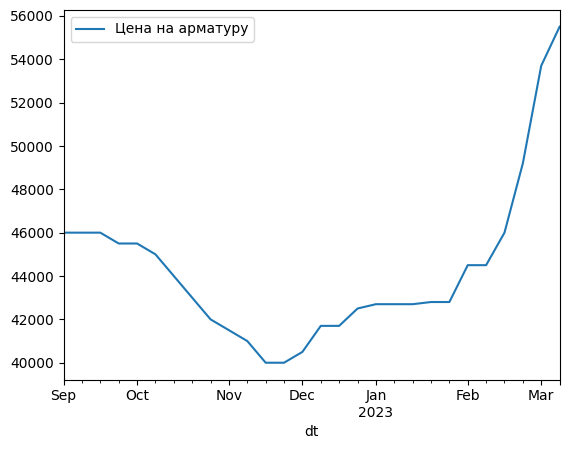

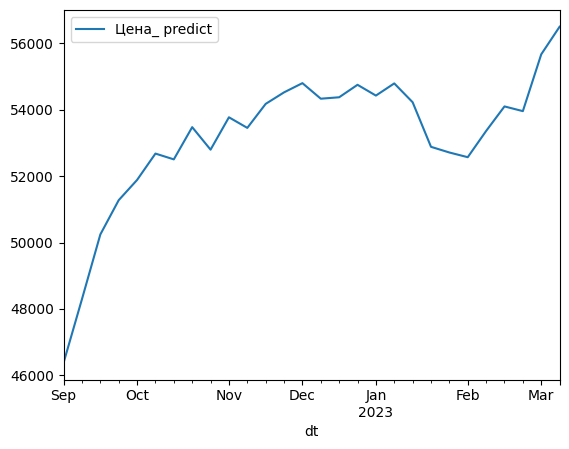

In [52]:
test.plot(x = 'dt', y = 'Цена на арматуру')
test.plot(x = 'dt', y = 'Цена_ predict')

In [53]:
test['flag'] = 0
test.loc[test.index[0], 'flag'] = 1
for i in range(2, len(test['Цена_ predict'])):
  if (test.iloc[i-2, 2] > test.iloc[i-1, 2]) & (test.iloc[i-1, 2] < test.iloc[i, 2]):
    test.loc[test.index[i-1], 'flag'] = 1

print(test.iloc[i, 2])

56505.715074308035


In [54]:
step = 1
test['step'] = 0
for i in range(len(test['step']))[::-1]:
  #print(i)
  test.loc[test.index[i], 'step'] = step
  if test.loc[test.index[i], 'flag'] == 0:
    step +=1
  else:
    step = 0

test['step'] = test['flag'] * test['step']
test = test[['dt', 'Цена_ predict', 'step']]
test.to_csv('test.csv')
test

,dt,Цена_ predict,step
0,2022-09-05,46376.741910,5
1,2022-09-12,48293.741710,0
2,2022-09-19,50243.279162,0
3,2022-09-26,51276.841521,0
4,2022-10-03,51886.550849,0
5,2022-10-10,52681.565696,0
6,2022-10-17,52506.778468,1
7,2022-10-24,53478.332898,0
8,2022-10-31,52799.519769,1
9,2022-11-07,53775.565597,0


# Дополнение
Доработать алгоритм выбора оптимального времени закупки по условиям. Не успеваю, доделаю завтра.